# Classifying Biological sex using FreeSurfer Volumetric Features 

- code based on: https://github.com/rmsouza01/AI2-Lab/tree/main/JNotebooks/Sex-classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data; replace special character, spaces and add Sex column
data = pd.read_excel("data-sample/volumetry_cc359.xlsx") # Reading the excel file
data.columns = data.columns.str.replace('[^A-Za-z0-9]+', '_').str.strip('_') #Replacing all the special characters and spaces in column name with underscore
data.dropna(axis=1, how='all', inplace=True) # Drops the NA values from the dataframe
data["Sex"] = data["Measure_volume"].apply(lambda x: x.split("_")[-1]) #Adding a new column to the dataframe called 'Sex' which identifies the gender.
data.head()

C:\Users\mariana\AppData\Local\Temp\ipykernel_20780\744258109.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace('[^A-Za-z0-9]+', '_').str.strip('_') #Replacing all the special characters and spaces in column name with underscore


,Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,Left_Hippocampus,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,EstimatedTotalIntraCranialVol,BrainSegVolNotVent_1,BrainSegVolNotVent_2,Age,Sex
0,CC0001_philips_15_55_M,14383.5,347.3,16704.9,65545.9,8355.0,3695.2,5246.1,2100.0,4626.1,...,260064.0,264149.0,524213,61929,711267.367273,1.756431e+06,1266382,1266382,55,M
1,CC0002_philips_15_56_M,5369.2,162.8,12668.8,53370.0,7143.5,3139.9,4500.7,1901.5,3521.0,...,204935.5,205957.5,410893,51286,589773.951269,1.393890e+06,1023139,1023139,56,M
2,CC0003_philips_15_63_F,3029.2,175.6,9510.2,39296.2,6056.8,2646.2,4096.1,1384.8,3350.2,...,173356.0,172522.0,345878,46208,504896.968842,1.259727e+06,867254,867254,63,F
3,CC0004_philips_15_67_M,8787.8,335.3,15830.3,53213.8,8423.4,3557.6,4689.5,2025.5,4326.0,...,275287.5,275054.5,550342,60029,678336.226332,1.805187e+06,1255855,1255855,67,M
4,CC0005_philips_15_62_M,8025.8,363.9,12819.5,55662.0,8333.7,3367.5,3873.6,2021.2,4483.1,...,219947.0,222454.0,442401,55998,653856.244352,1.651331e+06,1119780,1119780,62,M


C:\Users\mariana\anaconda3\envs\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


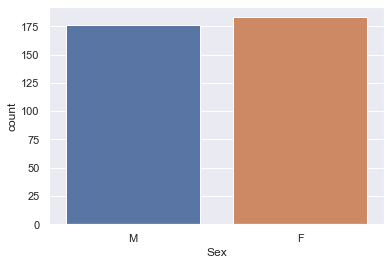

In [3]:
sns.set(style="darkgrid")
ax = sns.countplot(data["Sex"]) #plotting the Sex distribution from the DataFrame

In [4]:
## replaces the gender by 0/1, 0 for Female and 1 for Male ##
data.loc[data['Sex'] == "F", 'Sex'] = 0 
data.loc[data['Sex'] == "M", 'Sex'] = 1
data["Sex"] = data["Sex"].astype(int)
data.head()

,Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,Left_Hippocampus,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,EstimatedTotalIntraCranialVol,BrainSegVolNotVent_1,BrainSegVolNotVent_2,Age,Sex
0,CC0001_philips_15_55_M,14383.5,347.3,16704.9,65545.9,8355.0,3695.2,5246.1,2100.0,4626.1,...,260064.0,264149.0,524213,61929,711267.367273,1.756431e+06,1266382,1266382,55,1
1,CC0002_philips_15_56_M,5369.2,162.8,12668.8,53370.0,7143.5,3139.9,4500.7,1901.5,3521.0,...,204935.5,205957.5,410893,51286,589773.951269,1.393890e+06,1023139,1023139,56,1
2,CC0003_philips_15_63_F,3029.2,175.6,9510.2,39296.2,6056.8,2646.2,4096.1,1384.8,3350.2,...,173356.0,172522.0,345878,46208,504896.968842,1.259727e+06,867254,867254,63,0
3,CC0004_philips_15_67_M,8787.8,335.3,15830.3,53213.8,8423.4,3557.6,4689.5,2025.5,4326.0,...,275287.5,275054.5,550342,60029,678336.226332,1.805187e+06,1255855,1255855,67,1
4,CC0005_philips_15_62_M,8025.8,363.9,12819.5,55662.0,8333.7,3367.5,3873.6,2021.2,4483.1,...,219947.0,222454.0,442401,55998,653856.244352,1.651331e+06,1119780,1119780,62,1


In [5]:
#Printing all the column names to have a look at the oveall features we have
for col_name in data.columns:
    print(col_name, end =",")

Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,Left_Hippocampus,Left_Amygdala,CSF,Right_Lateral_Ventricle,Right_Inf_Lat_Vent,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_VentralDC,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,EstimatedTotalIntraCranialVol,BrainSegVolNotVent_1,BrainSegVolNotVent_2,Age,Sex,

C:\Users\mariana\anaconda3\envs\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


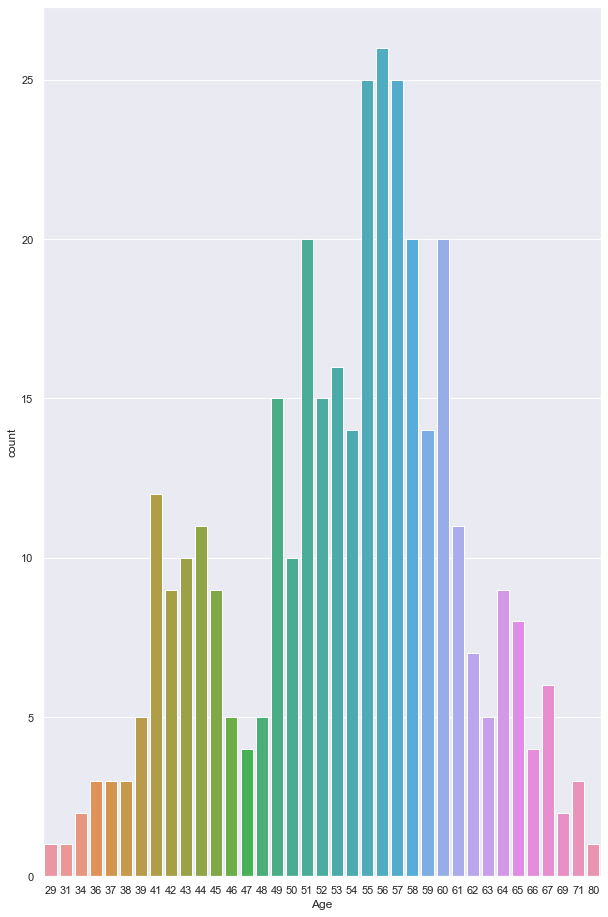

In [6]:
fig, ax = plt.subplots(figsize=(10,16))
sns.set(style="darkgrid")
ax = sns.countplot(data["Age"]) #plotting the Scanner distribution from the DataFrame

In [7]:
## Splitting dataset using stratified cross-validation##

to_drop = ["Sex"]
to_keep = ["Sex"]

X = data.drop(to_drop, axis = 1).to_numpy()[:,1:] #Drop irrelevant columns for training from testing feature set
y = data[to_keep].to_numpy()

skf = StratifiedKFold(n_splits=2,shuffle=False)
skf.get_n_splits(X, y)
print (skf)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [8]:
test_sets_accuracy = []
confusion = np.zeros((2,2))

# Random Forest Grid Search
param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, ]}

for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xtrain_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    print(Xtrain.shape)
    base_estimator = RandomForestClassifier(random_state=0)
    
    #Defining GridSearch with different parameters
    clf = GridSearchCV(base_estimator, param_grid=param_grid, n_jobs=6, cv = 4, scoring='accuracy', verbose=2, refit=True)
    clf.fit(Xtrain_scaled, Ytrain) 
    print(clf.best_params_) #Printing the best parameters
    Ypred = clf.predict(Xtest_scaled) #Predicting labels for test data
    accuracy = accuracy_score(Ytest, Ypred) #Calculating accuracy
    test_sets_accuracy.append(accuracy * 100.0) #Multiplying accuracy with 100 to get percentage value
    confusion+=(confusion_matrix(Ytest, Ypred))

(179, 41)
Fitting 4 folds for each of 288 candidates, totalling 1152 fits


C:\Users\mariana\anaconda3\envs\venv\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
(180, 41)
Fitting 4 folds for each of 288 candidates, totalling 1152 fits


C:\Users\mariana\anaconda3\envs\venv\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
print("Accuracy Achieved (mean +/- std): ", np.mean(test_sets_accuracy),np.std(test_sets_accuracy))

Accuracy Achieved (mean +/- std):  76.32526381129733 0.7697082557417758


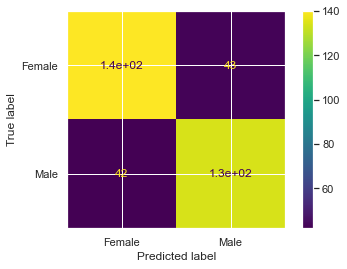

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                               display_labels=['Female', 'Male'])
disp.plot()
plt.show()